In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score
from math import sqrt

In [3]:
df = pd.read_csv('robberies.csv',parse_dates=True,index_col=0,header=0)
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['Robberies'])
df.columns=['Value']
     

In [4]:
df

,Value
Month,
1966-01,41
1966-02,39
1966-03,50
1966-04,40
1966-05,43
...,...
1975-06,316
1975-07,398
1975-08,394


In [5]:
df.head()

,Value
Month,
1966-01,41
1966-02,39
1966-03,50
1966-04,40
1966-05,43


In [6]:
df.tail()

,Value
Month,
1975-06,316
1975-07,398
1975-08,394
1975-09,431
1975-10,431


In [7]:
df.describe()

,Value
count,118.000000
mean,196.288136
std,128.043602
min,29.000000
25%,85.500000
50%,166.000000
75%,296.750000
max,500.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 1966-01 to 1975-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Value   118 non-null    int64
dtypes: int64(1)
memory usage: 1.8+ KB


In [9]:
df.isnull().sum()

Value    0
dtype: int64

In [10]:
#VISUALIZING THE DATA

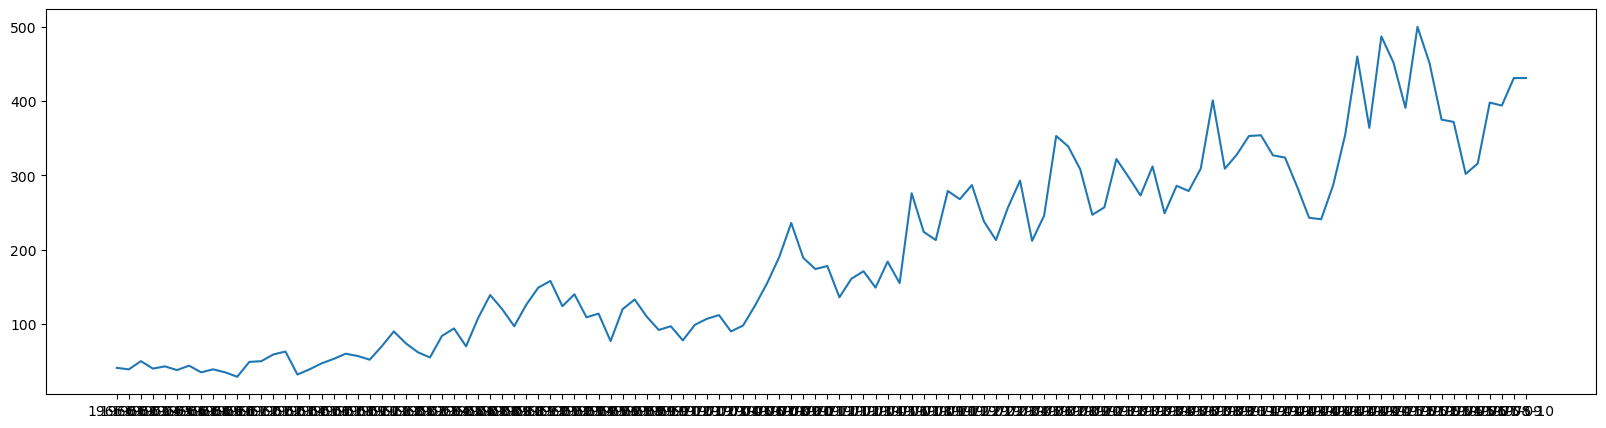

In [11]:
plt.figure(figsize=(20,5))
plt.plot(df)

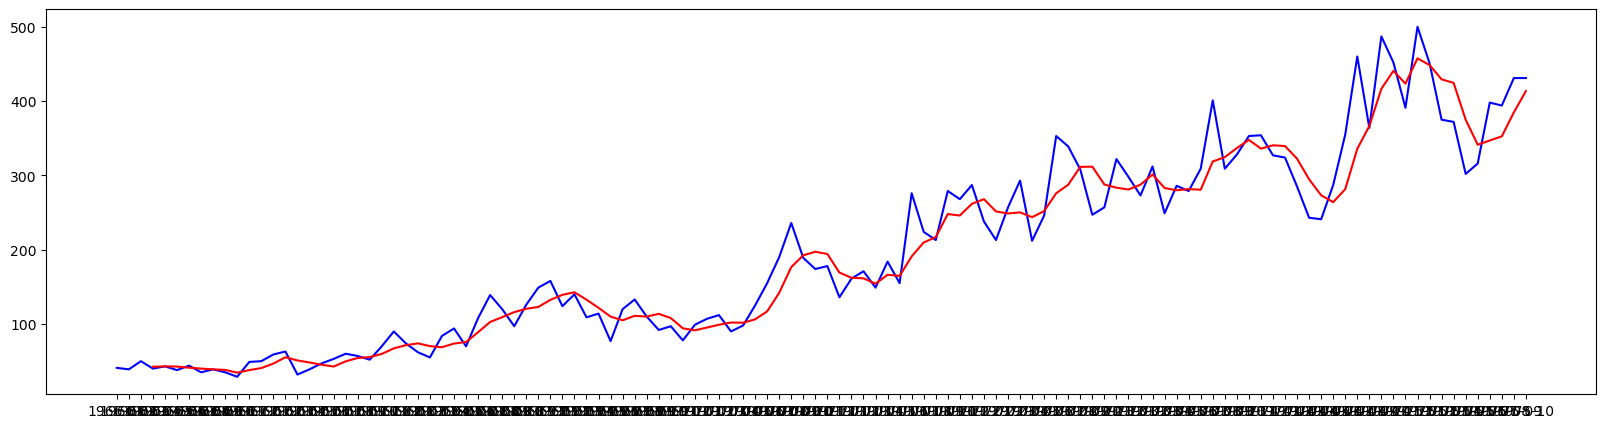

In [12]:
plt.figure(figsize=(20,5))
four_months_moving_average=df.rolling(window=4).mean()
plt.plot(df,color='blue')
plt.plot(four_months_moving_average,color='red')
plt.show()

<Axes: xlabel='Value', ylabel='Density'>

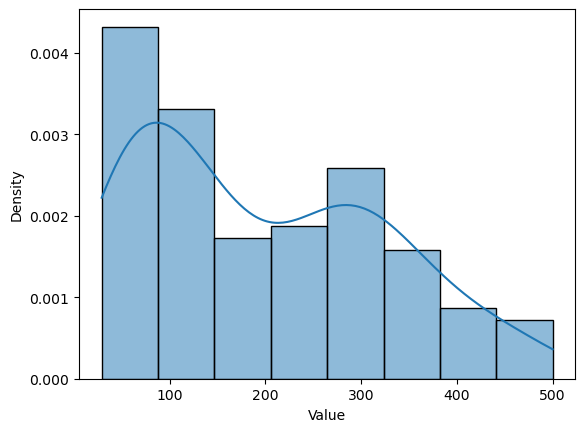

In [13]:
sns.histplot(df['Value'],kde=True,stat='density')

<Figure size 640x480 with 0 Axes>

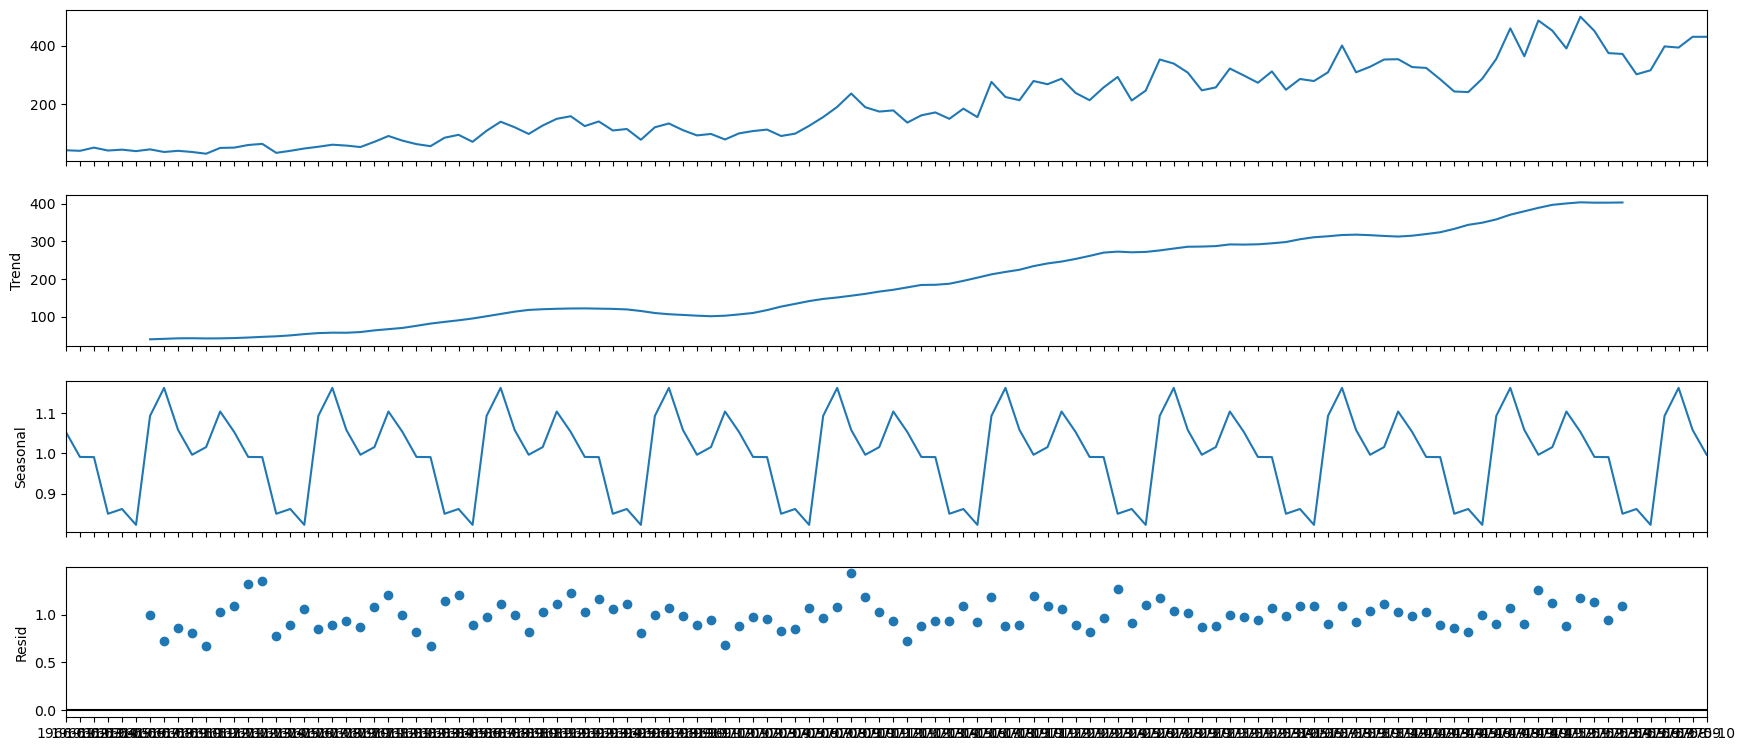

In [14]:
seasonal=seasonal_decompose(df,model='multiplicative',period=12)
fig=plt.figure()
fig=seasonal.plot()
fig.set_size_inches(20,8)

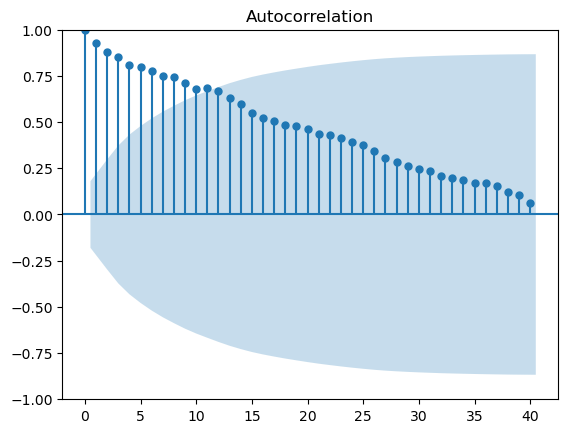

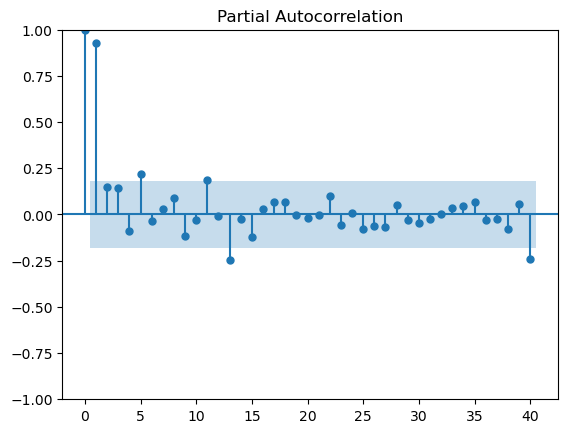

In [15]:
acf=plot_acf(df['Value'],lags=40)
pacf=plot_pacf(df['Value'],lags=40)

In [16]:
# ADF TEST(augumented dickey fuller test)

In [17]:
from statsmodels.tsa.stattools import adfuller

def adf_check(time_series):
    
    #Pass in a time series, returns ADF report

    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")
     

In [18]:
adf_check(df)

Augmented Dickey-Fuller Test:
ADF Test Statistic : 1.0011021402458182
p-value : 0.9942775638057234
Number of Lags Used : 11
Number of Observations Used : 106
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



In [19]:
#BUILDING ARIMA MODEL

#MATHEMATICAL EQUATION
#y't = C + ϕ1y't–1 +⋅⋅⋅ ϕp y't–p + θ1ϵ't–1 +⋅⋅⋅+ θqϵ't–q + ϵt
#1.MAKING THE DATA STATIONARY BY DIFFERENCING
#2.FITTING THE AUTO REGRESSIVE MODEL
#3.FITTING THE MOVING AVERAGE MODEL ON RESIDUALS

In [20]:
df1= pd.DataFrame(np.log(df.Value).diff().diff(1))
adf_check(df1.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.571432298108162
p-value : 7.918035308128113e-09
Number of Lags Used : 12
Number of Observations Used : 103
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Month'>

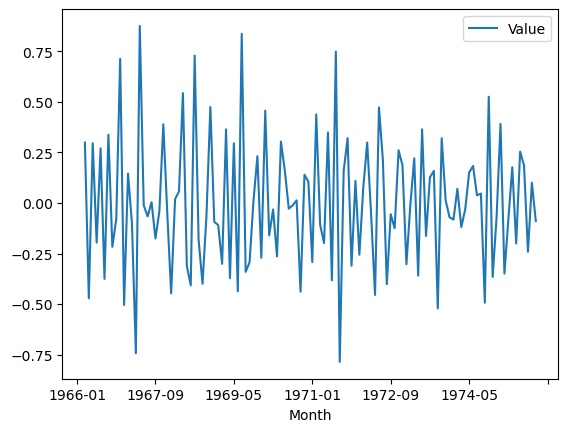

In [21]:
df1.plot()

In [22]:
#AR MODEL

In [23]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]
     


In [24]:


for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df1.Value))
  

The RMSE is : 0.19766560990996782 , Value of p :  1
The RMSE is : 0.17039561640953632 , Value of p :  2
The RMSE is : 0.1840086285578879 , Value of p :  3
The RMSE is : 0.18495799363853138 , Value of p :  4
The RMSE is : 0.18170582637105998 , Value of p :  5
The RMSE is : 0.1837664160736485 , Value of p :  6
The RMSE is : 0.1855590258460783 , Value of p :  7
The RMSE is : 0.185978870615149 , Value of p :  8
The RMSE is : 0.18745860640628162 , Value of p :  9
The RMSE is : 0.18251599381506084 , Value of p :  10
The RMSE is : 0.16201826198891547 , Value of p :  11
The RMSE is : 0.16199668569004932 , Value of p :  12
The RMSE is : 0.15084282427778833 , Value of p :  13
The RMSE is : 0.15235095553650338 , Value of p :  14
The RMSE is : 0.154025815495891 , Value of p :  15
The RMSE is : 0.1536618632338346 , Value of p :  16
The RMSE is : 0.15043652906142932 , Value of p :  17
The RMSE is : 0.15184885591479647 , Value of p :  18
The RMSE is : 0.1496960781211611 , Value of p :  19
The RMSE is

C:\Users\user\AppData\Local\Temp\ipykernel_4332\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_4332\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_4332\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [25]:
[df_train,df_test,theta,intercept,RMSE] = AR(12,pd.DataFrame(df1.Value))

The RMSE is : 0.16199668569004932 , Value of p :  12


C:\Users\user\AppData\Local\Temp\ipykernel_4332\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


<Axes: xlabel='Month'>

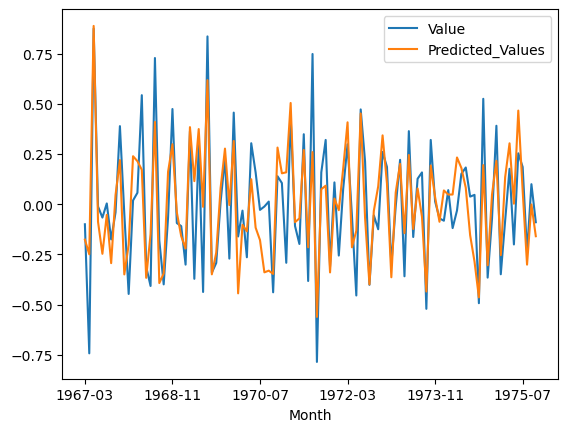

In [26]:
df2 = pd.concat([df_train,df_test])
df2[['Value','Predicted_Values']].plot()
     

In [27]:
res = pd.DataFrame()
res['Residuals'] = df2.Value - df2.Predicted_Values
     

In [28]:
res

,Residuals
Month,
1967-03,0.076643
1967-04,-0.493489
1967-05,-0.013102
1967-06,0.076345
1967-07,0.180575
...,...
1975-06,-0.212746
1975-07,0.119038
1975-08,0.060196


<Axes: ylabel='Density'>

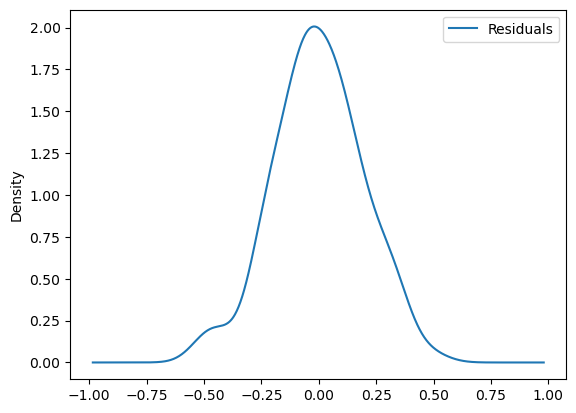

In [29]:
res.plot(kind='kde')

In [30]:
#MA MODEL

In [31]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]



C:\Users\user\AppData\Local\Temp\ipykernel_4332\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_4332\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_4332\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

The RMSE is : 0.17131048696911427 , Value of q :  1
The RMSE is : 0.17096093206710145 , Value of q :  2
The RMSE is : 0.17217346257079563 , Value of q :  3
The RMSE is : 0.17540807679940523 , Value of q :  4
The RMSE is : 0.17094604410885195 , Value of q :  5
The RMSE is : 0.1682338645396305 , Value of q :  6
The RMSE is : 0.16708307322396404 , Value of q :  7
The RMSE is : 0.16354231390834556 , Value of q :  8
The RMSE is : 0.16249043856064058 , Value of q :  9
The RMSE is : 0.1599951758552305 , Value of q :  10
The RMSE is : 0.16334299419185602 , Value of q :  11
The RMSE is : 0.16794295743199195 , Value of q :  12


C:\Users\user\AppData\Local\Temp\ipykernel_4332\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_4332\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_4332\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

The RMSE is : 0.1688490709608723 , Value of q :  13
The RMSE is : 0.1558176962726643 , Value of q :  14
The RMSE is : 0.15363074905077692 , Value of q :  15
The RMSE is : 0.1406931446838231 , Value of q :  16
The RMSE is : 0.15261652429398698 , Value of q :  17
The RMSE is : 0.15705216635484706 , Value of q :  18


C:\Users\user\AppData\Local\Temp\ipykernel_4332\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_4332\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_4332\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

The RMSE is : 0.15736356073067048 , Value of q :  19
The RMSE is : 0.154889886198111 , Value of q :  20


C:\Users\user\AppData\Local\Temp\ipykernel_4332\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


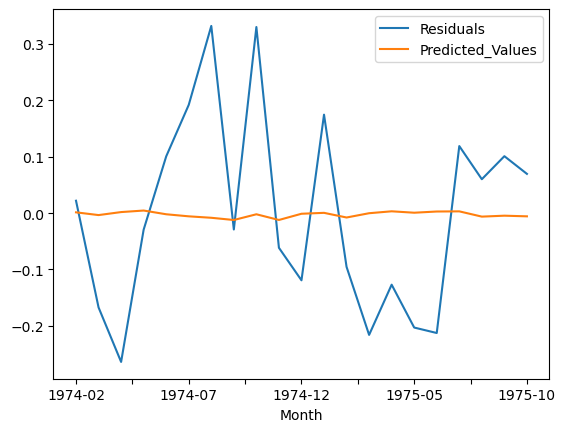

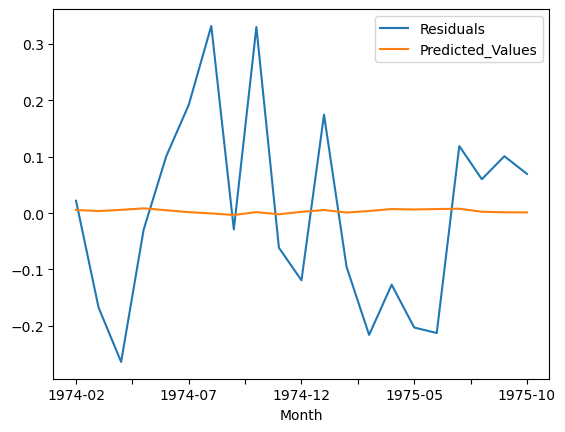

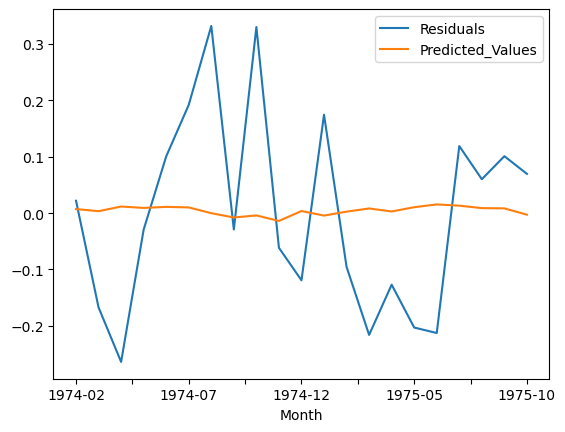

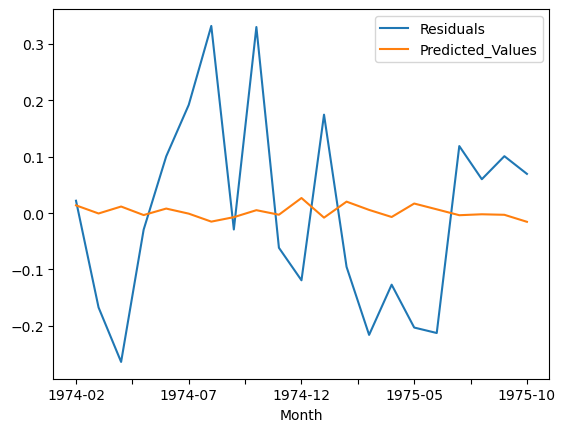

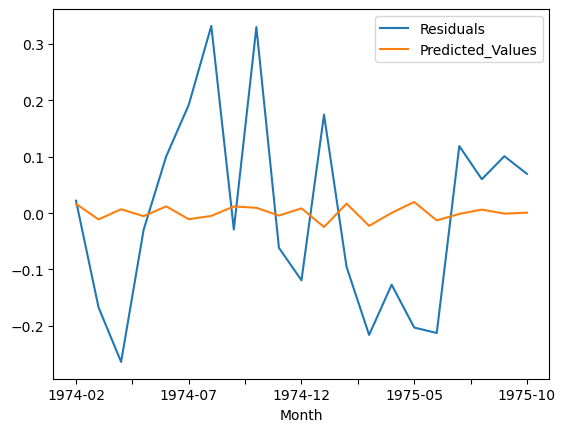

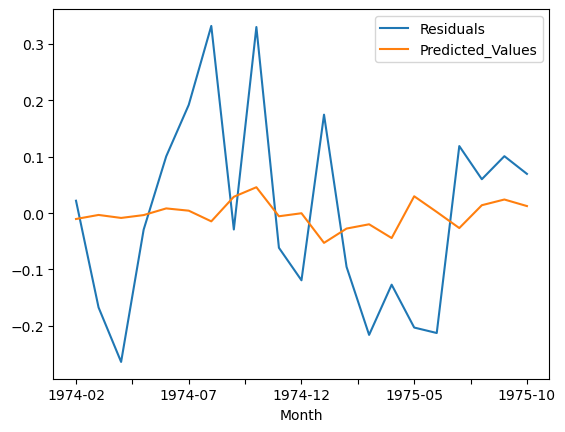

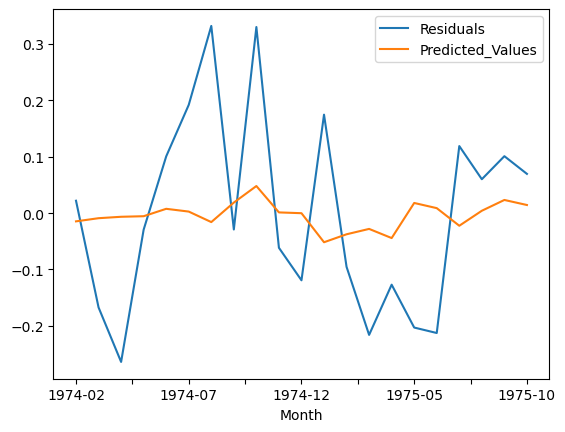

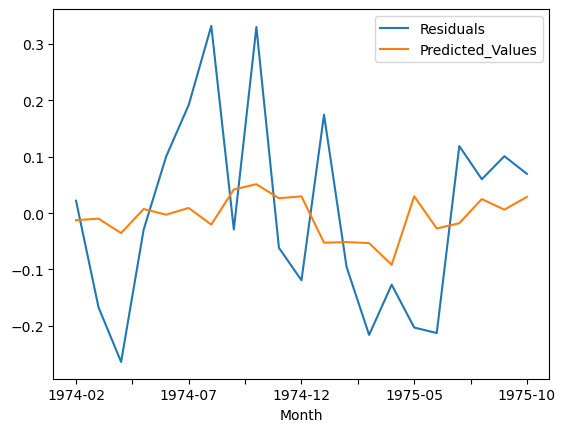

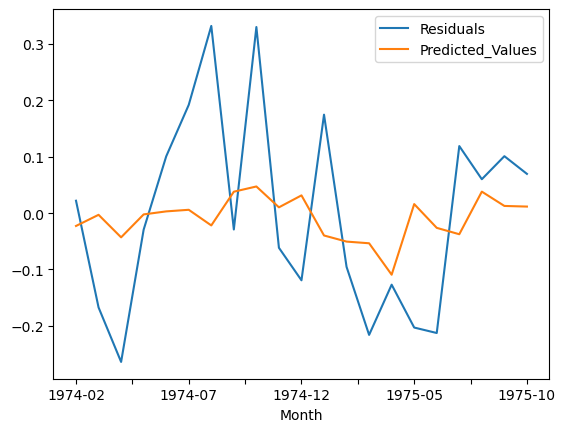

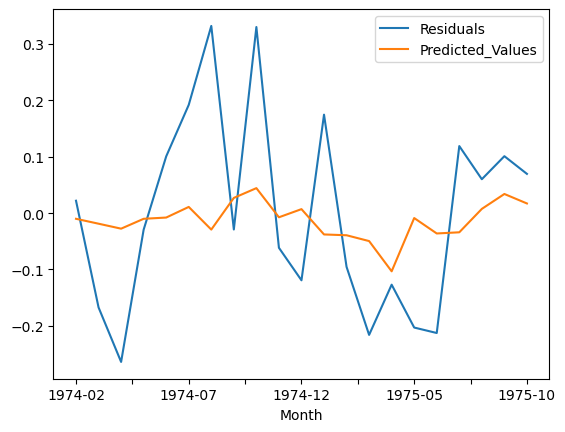

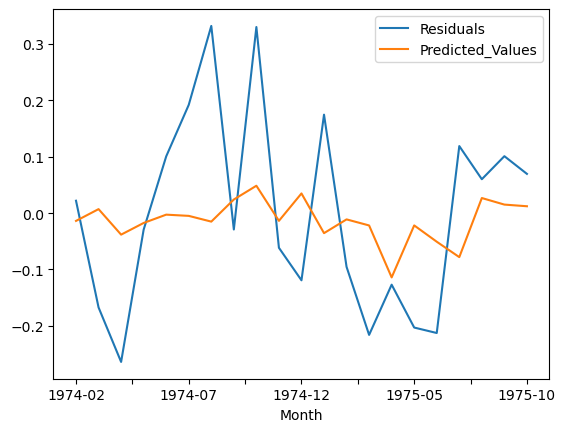

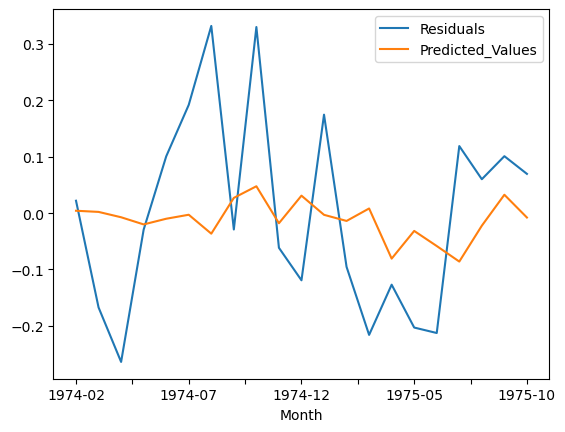

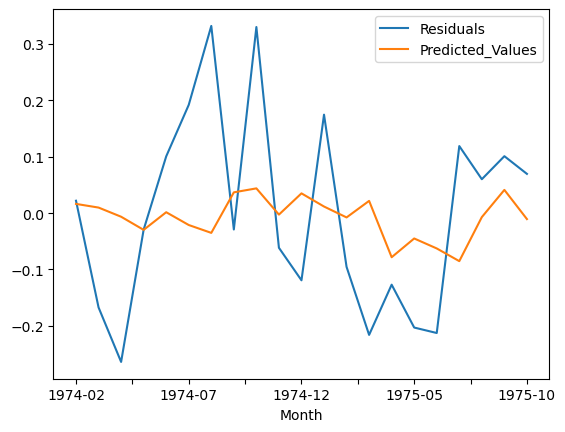

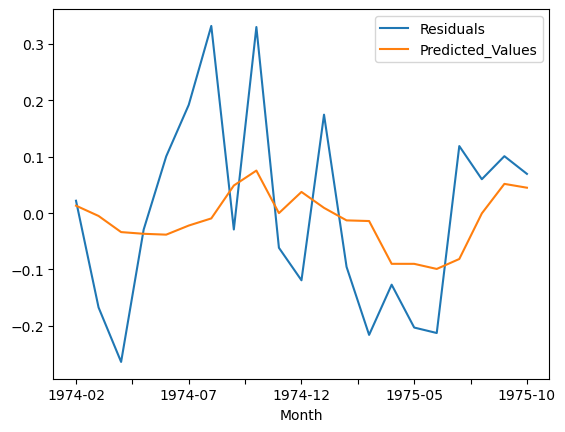

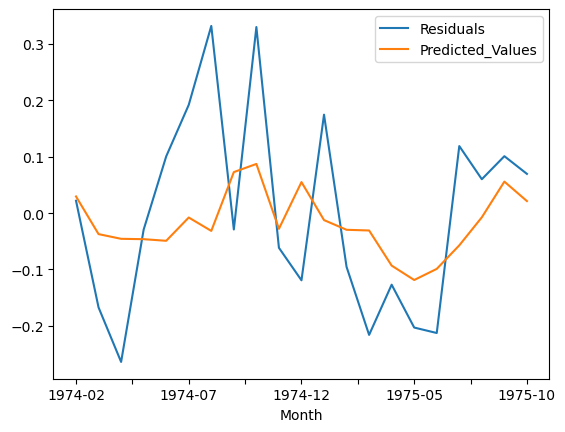

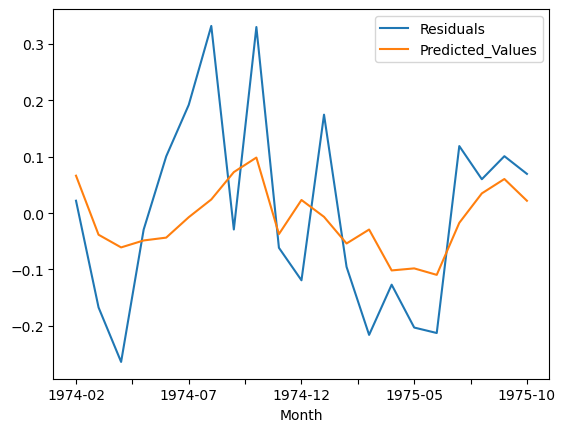

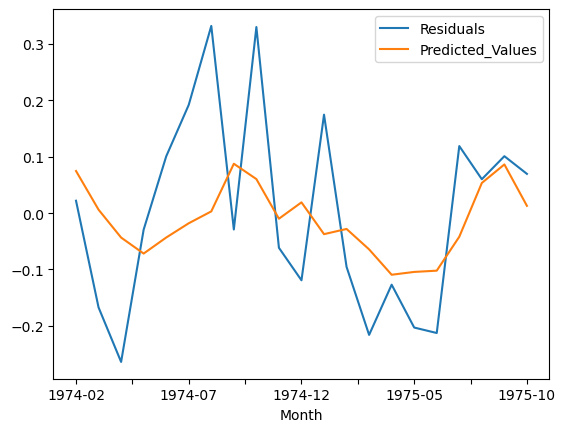

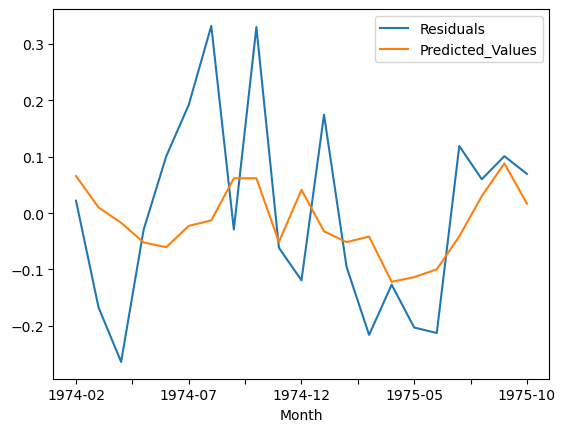

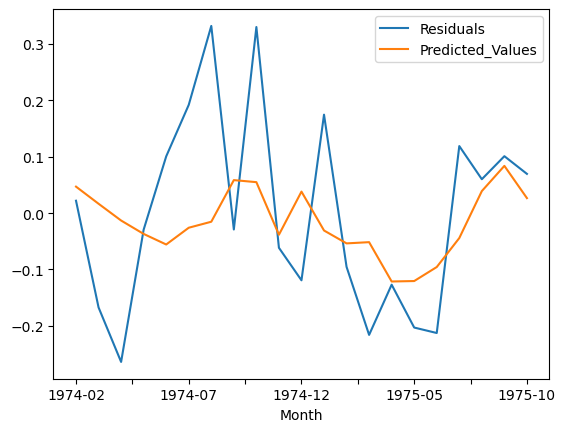

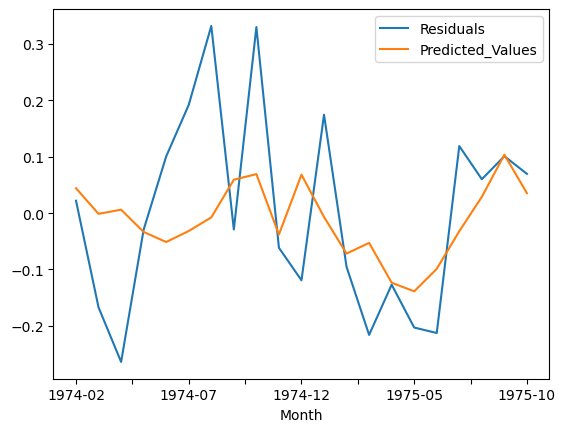

In [32]:


for i in range(1,21):
    
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
                                                                


The RMSE is : 0.16794295743199195 , Value of q :  12
[[-0.07481685]
 [ 0.01405407]
 [-0.05211034]
 [ 0.02380862]
 [-0.08233503]
 [-0.16356521]
 [ 0.00910921]
 [-0.0660269 ]
 [-0.12316954]
 [-0.12328664]
 [-0.08308811]
 [-0.08597243]]
[-0.00149157]


C:\Users\user\AppData\Local\Temp\ipykernel_4332\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


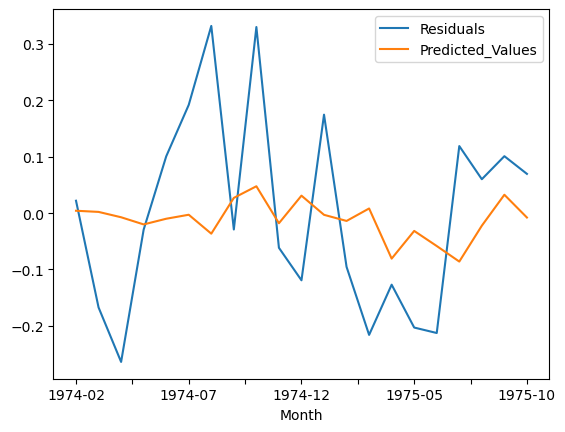

In [33]:
[res_train,res_test,theta,intercept,RMSE] = MA(12,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)
     

In [34]:
res1 = pd.concat([res_train,res_test])

In [35]:
res1

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
Month,,,,,,,,,,,,,,
1968-03,-0.157289,-0.220347,-0.244962,0.303819,0.168963,-0.086661,0.118340,0.056590,0.180575,0.076345,-0.013102,-0.493489,0.076643,0.002740
1968-04,0.371521,-0.157289,-0.220347,-0.244962,0.303819,0.168963,-0.086661,0.118340,0.056590,0.180575,0.076345,-0.013102,-0.493489,0.036644
1968-05,0.055704,0.371521,-0.157289,-0.220347,-0.244962,0.303819,0.168963,-0.086661,0.118340,0.056590,0.180575,0.076345,-0.013102,-0.121552
1968-06,-0.257798,0.055704,0.371521,-0.157289,-0.220347,-0.244962,0.303819,0.168963,-0.086661,0.118340,0.056590,0.180575,0.076345,-0.062872
1968-07,0.318469,-0.257798,0.055704,0.371521,-0.157289,-0.220347,-0.244962,0.303819,0.168963,-0.086661,0.118340,0.056590,0.180575,0.021153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975-06,-0.212746,-0.203063,-0.126983,-0.216099,-0.095381,0.174767,-0.119210,-0.061503,0.330338,-0.029016,0.332281,0.192178,0.100725,-0.058375
1975-07,0.119038,-0.212746,-0.203063,-0.126983,-0.216099,-0.095381,0.174767,-0.119210,-0.061503,0.330338,-0.029016,0.332281,0.192178,-0.085955
1975-08,0.060196,0.119038,-0.212746,-0.203063,-0.126983,-0.216099,-0.095381,0.174767,-0.119210,-0.061503,0.330338,-0.029016,0.332281,-0.022280


In [36]:
df2.Predicted_Values += res1.Predicted_Values
     


<Axes: xlabel='Month'>

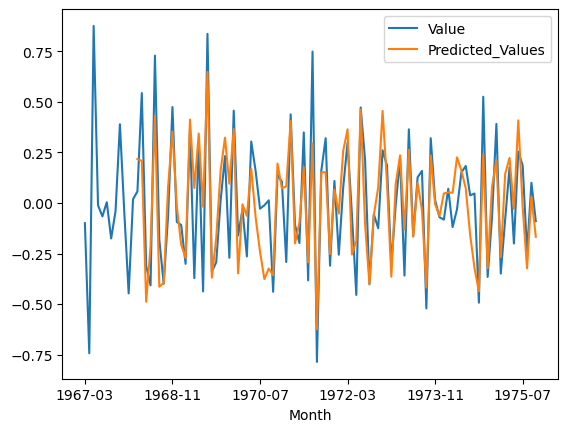

In [37]:
df2[['Value','Predicted_Values']].plot()
     

In [38]:
#PREDICTING THE VALUES

In [39]:
df2.Value += np.log(df).shift(1).Value
df2.Value += np.log(df).diff().shift(12).Value
df2.Predicted_Values += np.log(df).shift(1).Value 
df2.Predicted_Values += np.log(df).diff().shift(12).Value
df2.Value = np.exp(df2.Value)
df2.Predicted_Values = np.exp(df2.Predicted_Values)
     

In [40]:
df2

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
Month,,,,,,,,,,,,,,
1967-03,68.448501,0.145312,-0.504322,0.712577,-0.079839,-0.216427,0.337055,-0.375445,0.270217,-0.195935,0.295464,-0.471605,0.298472,NaN
1967-04,23.974603,-0.099917,0.145312,-0.504322,0.712577,-0.079839,-0.216427,0.337055,-0.375445,0.270217,-0.195935,0.295464,-0.471605,NaN
1967-05,82.539844,-0.742996,-0.099917,0.145312,-0.504322,0.712577,-0.079839,-0.216427,0.337055,-0.375445,0.270217,-0.195935,0.295464,NaN
1967-06,34.079905,0.875225,-0.742996,-0.099917,0.145312,-0.504322,0.712577,-0.079839,-0.216427,0.337055,-0.375445,0.270217,-0.195935,NaN
1967-07,50.922732,-0.011240,0.875225,-0.742996,-0.099917,0.145312,-0.504322,0.712577,-0.079839,-0.216427,0.337055,-0.375445,0.270217,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975-06,463.540766,-0.200435,0.176509,-0.081401,-0.349041,0.390875,-0.070393,-0.365692,0.525183,-0.493181,0.046473,0.037950,0.182950,540.916797
1975-07,470.488908,0.253782,-0.200435,0.176509,-0.081401,-0.349041,0.390875,-0.070393,-0.365692,0.525183,-0.493181,0.046473,0.037950,383.285417
1975-08,405.349565,0.185395,0.253782,-0.200435,0.176509,-0.081401,-0.349041,0.390875,-0.070393,-0.365692,0.525183,-0.493181,0.046473,373.259511


In [41]:
#PLOTTING THE VALUES AGAINST THE TEST DATA

<Axes: xlabel='Month'>

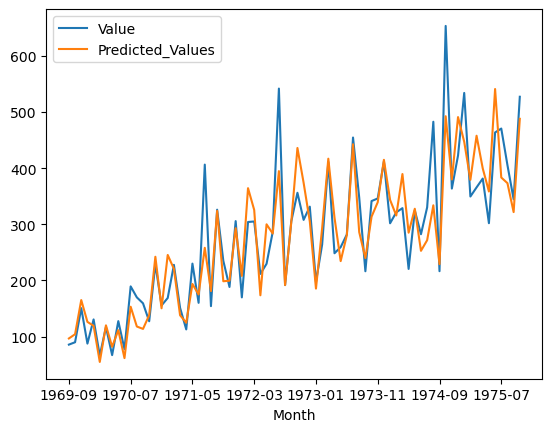

In [42]:
df2.iloc[30:,:][['Value','Predicted_Values']].plot()

In [43]:
vaf=df2.drop(['Shifted_values_1','Shifted_values_2','Shifted_values_3',
          'Shifted_values_4','Shifted_values_5','Shifted_values_6','Shifted_values_7','Shifted_values_8',
          'Shifted_values_9','Shifted_values_10','Shifted_values_11','Shifted_values_12','Predicted_Values'],axis=1)
vaf


,Value
Month,
1967-03,68.448501
1967-04,23.974603
1967-05,82.539844
1967-06,34.079905
1967-07,50.922732
...,...
1975-06,463.540766
1975-07,470.488908
1975-08,405.349565


In [44]:
bf=df2.drop(['Value','Shifted_values_1','Shifted_values_2','Shifted_values_3',
          'Shifted_values_4','Shifted_values_5','Shifted_values_6','Shifted_values_7','Shifted_values_8',
          'Shifted_values_9','Shifted_values_10','Shifted_values_11','Shifted_values_12'],axis=1)
bf

,Predicted_Values
Month,
1967-03,NaN
1967-04,NaN
1967-05,NaN
1967-06,NaN
1967-07,NaN
...,...
1975-06,540.916797
1975-07,383.285417
1975-08,373.259511


In [45]:
ddf=bf[12:]
ddf

,Predicted_Values
Month,
1968-03,82.260371
1968-04,34.409827
1968-05,62.826749
1968-06,91.608973
1968-07,121.481054
...,...
1975-06,540.916797
1975-07,383.285417
1975-08,373.259511


In [46]:
pf1=ddf

In [47]:
af=vaf[12:]
af

,Value
Month,
1968-03,70.095681
1968-04,48.096970
1968-05,75.011161
1968-06,75.384615
1968-07,163.542857
...,...
1975-06,463.540766
1975-07,470.488908
1975-08,405.349565


In [48]:
#PLOTTING THE GRAPH BETWEEN ACTUAL VALUE AND PREDICTED VALUE

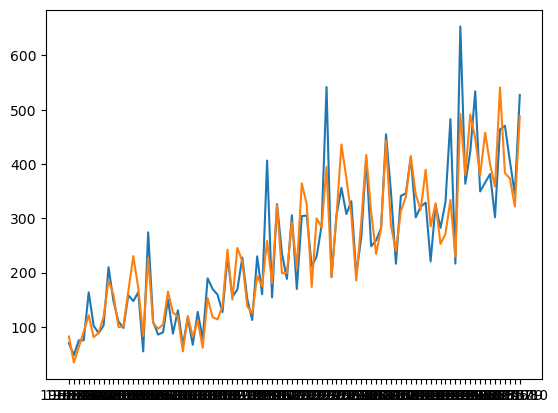

In [49]:
plt.plot(af)
plt.plot(ddf)

In [50]:
#CALCULATING RMSE AND MAPE VALUES

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(af['Value'],ddf['Predicted_Values']))

print('RMSE:',rmse)

RMSE: 48.414058817773665


In [52]:
from sklearn.metrics import mean_absolute_percentage_error

mape=mean_absolute_percentage_error(af['Value'],ddf['Predicted_Values'])

print('MAPE:',mape)

MAPE: 0.14449043706923534


In [53]:
#FITTING THE ARIMA MODEL ON THE DATASET USING AUTO ARIMA FUNCTION

In [54]:
#TRAIN AND TEST SPLIT

In [55]:

train_size = (int)(0.8 * df.shape[0])



In [56]:
train = pd.DataFrame(df[0:train_size])
test = pd.DataFrame(df[train_size:df.shape[0]])


In [57]:
test

,Value
Month,
1973-11,353
1973-12,354
1974-01,327
1974-02,324
1974-03,285
1974-04,243
1974-05,241
1974-06,287
1974-07,355


In [58]:
#TRAIN AND TEST PLOT

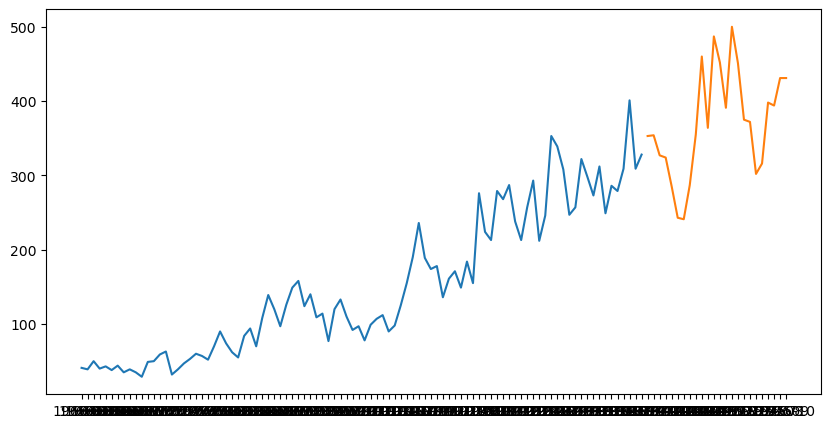

In [59]:
plt.figure(figsize=(10,5))
plt.plot(train)
plt.plot(test)

In [60]:
#USING AUTO ARIMA FUNCTION TO FIT THE MODEL

In [61]:
arima_model=auto_arima(train,start_p=0,d=1,start_q=0,
                      start_P=0,D=1,start_Q=0,
                      max_p=20,max_q=20,max_d=20,
                      max_P=20,max_Q=20,max_D=20,m=12,
                      seasonal=True,error_action='warn',
                      trace=True,supress_warnings=True,
                      stepwise=True,
                      random_state=20,n_fits=10)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=851.375, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=823.319, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=801.833, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=829.937, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=803.783, Time=0.27 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=803.763, Time=0.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=813.391, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=803.141, Time=0.22 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=802.964, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=811.060, Time=0.13 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=801.414, Time=0.47 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=in

In [67]:
pf1=pd.DataFrame(arima_model.predict(n_periods=29),index=test.index)
pf1.columns=['predicted-robberies']

In [69]:

pf1

,predicted-robberies
Month,
1973-11,342.952212
1973-12,341.125959
1974-01,339.255820
1974-02,318.742379
1974-03,346.954131
1974-04,324.708367
1974-05,330.167359
1974-06,325.743886
1974-07,382.533845


In [63]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   94
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -395.707
Date:                              Fri, 13 Oct 2023   AIC                            801.414
Time:                                      16:36:42   BIC                            813.386
Sample:                                  01-01-1966   HQIC                           806.217
                                       - 10-01-1973                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6796      0.227     -2.992      0.003      -1.125      -0.234
ma.L1          0.2237      0.240      0.933      0.351      -0.246       0.694
ma.L2         -0.5832      0.094     -6.191      0.000      -0.768      -0.399
ma.S.L12      -0.7905      0.146     -5.431      0.000      -1.076      -0.505
sigma2       865.2415    120.815      7.162      0.000     628.449    1102.034
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 2.31
Prob(Q):                              0.72   Prob(JB):                         0.32
Heteroskedasticity (H):               4.76   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""